In [1]:
NAME = "" # put your full name here
COLLABORATORS = [] # list names of anyone you worked with on this homework.

# [ERG 131] Homework 8: Model Selection and Regularization

This assignment explores methods that answer the question of how to choose which features to include in a model. In HW7 (resampling), we used cross-validation to evaluate how well different models generalize to new data, and one of the big takeaways was that using too many features can cause us to over-fit our model on the training data, and lead to a model that performs poorly on test data. In this HW, we'll look at three methods that attempt to reduce model variance by prioritizing certain model features: best subset selection, ridge regression, and lasso regression.

A good reference for this HW is ISLR Ch. 6.

### Table of Contents

1. [The data](#data)<br>
1. [Comparing linear, ridge, and lasso regression](#models)<br>
1. [Choosing lambda](#lambda)<br>
1. [Comparing optimal models](#compare)<br>
1. [Project](#proj)

In [2]:
# Run this block

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_context("talk")
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

np.random.seed(1)

## Section 1: The Data<a name='data'></a>

We're going to be working (for the third and final time!) with the Novotny et al. LUR data. You will recognize it from HW5 and lab 8. As a refresher:

* The data is an accumulation of GIS land-use characteristics from land-monitoring from the EPA, and in situ NO2 measurements from satellite sensors.
* The goal of land-use regression (LUR) is to estimate outdoor air pollution geospatially across the contiguous United States.
* The reason for the high number of data points is that the data keeps track of readings from monitors at a high resolution, up to ~30 meters.

First, let's upload the data to dataframe `df`.

In [3]:
# run this cell
df = pd.read_csv('data/BechleLUR_2006_allmodelbuildingdata.csv')
df.head(10)

,Monitor_ID,State,Latitude,Longitude,Observed_NO2_ppb,Predicted_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,...,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
0,04-013-0019-42602-1,AZ,33.483850,-112.142570,23.884706,20.986643,11.615223,313.0,0.304,59.4431,...,1788.38015,2637.91917,2862.73591,3096.99468,3339.22952,3609.20650,3896.25748,4150.54739,4396.96011,4651.18890
1,04-013-3002-42602-6,AZ,33.457930,-112.046010,25.089886,20.990096,11.472677,323.8,0.304,72.0000,...,1731.04787,2562.32948,2791.32295,3015.79024,3248.95785,3489.76919,3723.01595,3963.41655,4196.37496,4459.57421
2,04-013-3003-42602-1,AZ,33.479680,-111.917210,19.281969,18.088153,8.990372,308.4,0.304,53.0000,...,1254.14847,1965.43346,2157.42878,2362.96458,2584.38952,2820.52494,3052.44507,3315.05126,3607.37536,3921.12841
3,04-013-3010-42602-1,AZ,33.460930,-112.117480,30.645138,20.358009,11.919268,309.0,0.304,61.3099,...,1599.66889,2449.51041,2660.60636,2879.53599,3109.74604,3339.37790,3597.15279,3848.61451,4125.08884,4427.95530
4,04-013-4011-42602-1,AZ,33.370050,-112.620700,11.070412,8.549622,2.141366,269.5,0.293,12.0000,...,149.29461,222.34687,244.41106,269.54740,293.31410,320.37722,349.76462,386.03419,412.91888,441.52860
5,04-013-9997-42602-1,AZ,33.503731,-112.095809,22.393566,20.942856,11.731892,314.7,0.304,66.0000,...,2010.17084,3014.84744,3262.36877,3500.22514,3732.97025,3957.86612,4194.27832,4440.12141,4707.73501,4996.20249
6,04-019-1011-42602-1,AZ,32.204411,-110.878667,15.749855,13.394496,2.031462,275.1,0.304,57.0000,...,1569.63377,2414.22062,2634.50616,2842.95309,3072.81520,3278.31648,3479.05149,3688.38977,3881.19939,4077.03977
7,04-019-1028-42602-1,AZ,32.295150,-110.982300,14.773313,12.245109,2.130547,271.6,0.304,48.0000,...,1360.56333,2061.10625,2245.68336,2423.54886,2596.69875,2764.40073,2947.00698,3143.10559,3324.94354,3504.52518
8,04-027-0006-42602-1,AZ,32.677855,-114.475861,10.412472,5.909958,0.026118,112.4,0.063,16.0000,...,557.50084,792.65848,848.94399,895.22375,936.58728,978.27742,1026.14093,1075.12710,1126.49198,1180.13544
9,05-035-0005-42602-1,AR,35.197288,-90.193141,11.915892,8.151799,3.711561,629.7,0.065,24.0641,...,536.08642,736.96695,765.98493,791.17568,819.67907,839.52606,862.01374,889.19455,921.36303,949.34936


In this lab, we're going to be creating models for two sets of data: one for the full dataset, and one for just California data. We'll be looking at how different approaches (subset selection, lasso, and ridge) perform with datasets that have more or less observations.

**Question 1.1** To get started, create a dataframe `df_ca` that contains just California observations from dataframe `df`.

In [5]:
# solution
df_ca = df[df["State"] == "CA"]
df_ca.head()

,Monitor_ID,State,Latitude,Longitude,Observed_NO2_ppb,Predicted_NO2_ppb,WRF+DOMINO,Distance_to_coast_km,Elevation_truncated_km,Impervious_100,...,total_8000,total_10000,total_10500,total_11000,total_11500,total_12000,total_12500,total_13000,total_13500,total_14000
11,06-001-0007-42602-1,CA,37.687500,-121.784200,14.147250,11.608541,5.311018,41.4,0.138,45.0138,...,778.61432,1012.95550,1078.80008,1153.97517,1219.00105,1284.70826,1345.43782,1402.66736,1478.50461,1561.93413
12,06-001-1001-42602-1,CA,37.535800,-121.961900,15.251911,12.978656,7.423307,16.3,0.018,45.1205,...,1089.87882,1414.84562,1496.89958,1578.00839,1668.95293,1753.24858,1834.50911,1921.03406,2003.20226,2087.82179
13,06-007-0002-42602-1,CA,39.757500,-121.842222,9.294462,7.969050,0.260948,215.5,0.061,47.0000,...,848.81897,1018.08439,1057.37944,1096.26374,1130.57906,1165.51881,1204.35253,1247.93593,1291.50689,1327.76177
14,06-013-0002-42602-1,CA,37.936000,-122.026200,10.801078,12.228855,6.422275,30.2,0.060,43.3642,...,1459.94209,2034.26798,2164.75244,2289.96458,2406.21816,2518.54920,2648.36369,2767.16147,2880.30511,2976.34533
15,06-013-1002-42602-1,CA,38.010556,-121.641389,7.859504,6.898745,4.341748,68.9,0.001,5.1292,...,232.18954,371.79731,412.44104,447.39788,484.86451,529.19387,602.25997,667.65750,730.46139,804.26487


In [6]:
assert df_ca.shape == (94,135)

**Question 1.2** As with the lab, we want to predict Observed_NO2_ppb and we want to use all the columns except for Monitor_ID, State, Latitude, Longitude, Observed_NO2_ppb, and Predicted_NO2_ppb as features.

Write a function `get_X_y()` that takes as input a dataframe, and returns four dataframes: X_train, X_test, y_train, and y_test. Remember to start by selecting only the X values (all the columns except for the ones listed above) and the one y value (observed NO2). Then, call that function on `df` and `df_ca`, and save the resulting dataframes to `X_all_train, X_all_test, y_all_train, y_all_test` and `X_ca_train, X_ca_test, y_ca_train, y_ca_test` respectively.

Write your function to hold 20% of the data as test data, with a `random_state` of 123456 as input to `train_test_split()`.  This is important!  The assert functions won't work if you don't use that random state.  

In [8]:
# solution
from sklearn.model_selection import train_test_split

def get_X_y(df):
    """
    This function returns two dataframes containing the X and y values used in land-use regression.
    Input: df, a Pandas dataframe with all of the fields in the land-use regression dataset
    Returns: X_train, X_test, y_train, y_test, four dataframes containing the training and testing subsets of the 
    feature matrix X and response matrix y
    """
    
    X = df.drop(columns = ["Monitor_ID", "State", "Latitude", "Longitude", "Observed_NO2_ppb", "Predicted_NO2_ppb"])
    y = df[["Observed_NO2_ppb"]]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 123456)
    
    return X_train, X_test, y_train, y_test

X_all_train, X_all_test, y_all_train, y_all_test = get_X_y(df) # get X and y train and test dataframes for full dataset
X_ca_train, X_ca_test, y_ca_train, y_ca_test = get_X_y(df_ca) # get X and y train and test dataframes for CA data

In [9]:
# check dimensions of output dataframes
assert X_ca_train.shape[0] == y_ca_train.shape[0]
assert X_all_test.shape[0] == y_all_test.shape[0] == round(X_all_train.shape[0]/4)
assert X_ca_test.shape[1] == X_all_test.shape[1] == 129

## Section 2: Comparing linear, ridge, and lasso regression<a name='models'></a>

Our feature matrix has a very high number of features in it (129 to be exact). It would be a big hassle to try and determine the weight of importance from each variable (that would take ages!). So how should we do it?

As a recap from lab 8 and from lecture, for a normal regression, a model with two features would have a model that looks like this:

$$\Large \hat{y} = \theta_1 x_{1i} + \theta_2 x_{2i}$$

However, there is the possibility such that one of the indicator variables does not have as much of an impact on the value of the predicted variable as originally intended when tested on unseen data. Conversely, there could also be similar variables that are not given equal weight. This would cause an overfitting problem later, meaning that the graph would have high variance. How would we fix this problem?

Enter the **ridge regression ($L^2$ regularization)**. This formula takes the minimization of mean squared error that we do with linear regression formula and adds a **regularization** or **penalty** term. Visually...

$$ \large \hat{\theta} = \arg \min_\theta \frac{1}{n} \sum_{i=1}^n \textbf{Loss}\left(y_i, \hat{y_i}\right) + \lambda {R_{L^2}}(\theta) $$

where $\large R_{L^2}(\theta) = \sum_{k=1}^p (\theta_k)^2$ 

In the case of Lasso regression, we would uses the penalty term $\large R_{L^1}(\theta) = \sum_{k=1}^p \Big|\theta_k\Big|$, where $p$ is the number of model features.

The higher the value of $\large \lambda$, the more a model is penalized for reaching outsider values. Essentially, we are decreasing variance, and increasing bias with our higher lambda value.

For the purposes of `sklearn`, the lambda value will be passed in as an argument `alpha`, where $$\alpha = \lambda$$

However, what value of $\lambda$ would be a good sized penalty term? We need to check a few answers to find a good option for this term. What is a technique that we know that can will check for the "best fit" across different terms? You guessed it: cross-validation! We'll be doing cross validation in the next section. For now, let's see how our models perform on a random train-test split.

**Question 2.1** In this homework we're going to compare the results of three models: a simple linear regression, ridge regression, and lasso regression. As we know from lab 8, `scikit-learn` has a very generalizable syntax when it comes to using different models, where you instantiate a model and save that instance of the model to a variable (eg. `lm = LinearRegression()`), then use `.fit()` to fit that model to the training data and `.predict()` to output predictions for test data.

In this question, we're going to complete a function `fit_model()` that automates the process of initializing a model, fitting that model, and getting predictions. The function should return two sets of values: the model coefficients, and the test mean squared error of the model.

We've gotten you started with some skeleton code. It may be helpful to test out each part of the function separately, and then put it all together. It also may be helpful to look back at lab 8 to see how we initialize and fit different models.

*Hint:* When getting the coefficients of a model using `.coef_`, sometimes scikit-learn returns a 1D array and sometimes it returns a nested array (i.e. with double brackets). To make sure that the dimensions of the coefficients that you output using this function are always the same, consider using the [numpy .flatten() method](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html).

*Another hint:* We're fitting one of three potential models here: LinearRegression(), Ridge(), and Lasso(). While Ridge() and Lasso() take in an alpha argument, LinearRegression() does not! That means your code has to check what type of model you'll be fitting before initializing that model and passing an alpha argument to it.

In [11]:
# solution
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

def fit_model(Model, X_train, X_test, y_train, y_test, alpha = 1):
    """
    This function fits a model of type Model to the data in the training set of X and y, and finds the MSE on the test set
    Inputs: 
        Model (sklearn model): the type of sklearn model with which to fit the data - LinearRegression, Ridge, or Lasso
        X_train: the set of features used to train the model
        y_train: the set of response variable observations used to train the model
        X_test: the set of features used to test the model
        y_test: the set of response variable observations used to test the model
        alpha: the penalty parameter, to be used with Ridge and Lasso models only
    """    
    if Model == LinearRegression:
        model = Model()
    else:
        model = Model(alpha = alpha)
        
    model.fit(X_train, y_train)
    mse = mean_squared_error(y_test, model.predict(X_test))
    coef = model.coef_.flatten()
    
    return mse, coef

In [12]:
# run this cell to confirm that fit_model() works as expected

# check the MSE of using Ridge regression on the full data - the value should be ~ 17 if your random_state was 123456 in get_X_y
assert 17 < fit_model(Ridge, X_all_train, X_all_test, y_all_train, y_all_test)[0] < 18

# make sure that the number of coefficients is equal to the number of features
assert len(fit_model(LinearRegression, X_all_train, X_all_test, y_all_train, y_all_test)[1]) == 129

# check that Lasso is reducing the coefficients as expected - i.e. by setting some coefficients to zero
assert np.count_nonzero(fit_model(Lasso, X_all_train, X_all_test, y_all_train, y_all_test)[1]) < len(fit_model(Lasso, X_all_train, X_all_test, y_all_train, y_all_test)[1])

**Question 2.2** For each set of data (the training and testing sets of `X_all, y_all` and `X_ca, y_ca` obtained in question 1.2), call `fit_model()` 3 times: once with `Model = LinearRegression`, once with `Model = Ridge` and once with `Model = Lasso`. For ridge and lasso, you can leave the `alpha` value as its default value (1). Save both the MSE and the coefficient output everytime you run the models. You'll end up with 6 MSE values and 6 sets of coefficients (3 for the full dataset and 3 for California; 1 per model type in each case). It's up to you how you store the values (you can use lists or arrays or separate variable names, as long as you're able to access the MSE values and coefficients later in the lab). 

In [14]:
# possible solution

Models = [LinearRegression, Ridge, Lasso] # list of models

# list that will hold MSE values - each element corresponds to a model in Models
mse_all = np.zeros(len(Models))
mse_ca = np.zeros(len(Models))

# initialize array that will hold coefficients - each column corresponds to a model in Models
coef_all = np.zeros((X_all_train.shape[1], len(Models)))
coef_ca = np.zeros((X_ca_train.shape[1], len(Models)))

for Model, i in zip(Models, np.arange(len(Models))):
    mse_all[i], coef_all[:,i] = fit_model(Model, X_all_train, X_all_test, y_all_train, y_all_test)
    mse_ca[i], coef_ca[:,i] = fit_model(Model, X_ca_train, X_ca_test, y_ca_train, y_ca_test)

**Question 2.3** Create a plot with two subplots below. In the first subplot, plot the coefficients for ridge regression, lasso regression, and the linear model for the full dataset. In the second, plot the same but for the California data. You can use whatever type of plot makes the most sense. Make sure to have axis labels, titles, and legends.

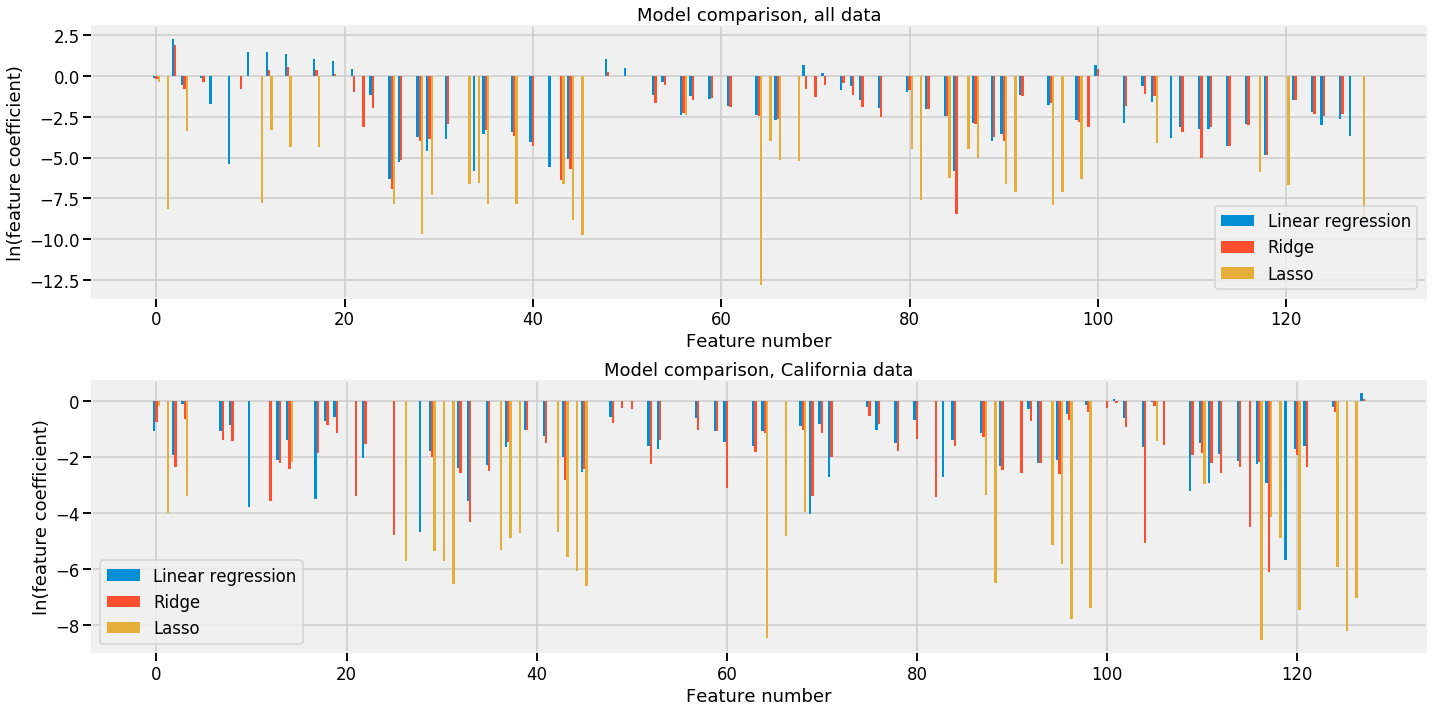

In [38]:
# possible solution
ind = np.arange(coef_all.shape[0])
width = 0.25
pos = np.array([ind - width, ind, ind + width])
modelNames = ["Linear regression", "Ridge", "Lasso"]

plt.figure(figsize = (20,10))

plt.subplot(211)
for i in np.arange(coef_all.shape[1]):
    plt.bar(pos[i], height = np.log(coef_all[:,i]), width = width, label = modelNames[i])
plt.legend()
plt.xlabel("Feature number")
plt.ylabel("ln(feature coefficient)")
plt.title("Model comparison, all data")


plt.subplot(212)
for i in np.arange(coef_all.shape[1]):
    plt.bar(pos[i], height = np.log(coef_ca[:,i]), width = width, label = modelNames[i])
plt.legend()
plt.xlabel("Feature number")
plt.ylabel("ln(feature coefficient)")
plt.title("Model comparison, California data")

plt.tight_layout()
plt.show()

**Question 2.4** How do the coefficients from lasso, ridge, and linear regression compare for the full dataset? How about for the California data? Based on your knowledge of lasso, ridge, and linear regression, can you explain why the coefficients compare in this way?

**Answer** For both datasets, Lasso coefficients are consistently much smaller (or zero). Ridge coefficients also tend to be smaller than Linear Regression coefficients for both datasets, although on occaision for both datasets Ridge coefficients are slightly larger than Linear Regression coefficients. Ridge and Lasso will tend to be smaller than Linear Regression coefficients because they have a penalty term that penalizes adding more coefficients, or having larger magnitude coefficients - this leads to their optimal solution having smaller coefficient values. Lasso has 0-value coefficients because its penalty term allows for 0-coefficient solutions, while ridge does not.

**Question 2.5** Compare the 3 test MSES from the full dataset and from the California dataset. How do the MSEs compare within model types (i.e. how does the MSE for linear regression fit on the California model compare with that fit on the full model)? Can you explain how the two sets of values compare, based on what you know about bias and variance? 

Particularly, note how the MSEs change for the California data when Lasso is used vs. for all data when Lasso is used. Which set of data exhibits a larger improvement when Lasso is used? Why do you think that is?

You don't have to use a visualization for this question, although you are welcome to.

In [18]:
# solution
print("California: ", mse_ca)
print("Full dataset: ", mse_all)

California:  [300.57765869 168.86894662  34.1706934 ]
Full dataset:  [17.98944948 17.18471901 10.57588766]


**Possible answer**: MSEs for the California data are consistently higher than they are for the full dataset, *but* lasso regression leads to a much more noticeable improvement for the California data (MSE = 134-140 to MSE = 22 with Lasso) than it does for the full dataset (MSE = 13 to MSE = 11 for Lasso). Our California models are exhibiting a lot more variance in general - this makes sense because we have a smaller set of observations, which increases our risk of overfitting the models. But the performance of the Lasso model indicates that it's especially beneficial to eliminate some features when you have a relatively small number of observations relative to the number of features.

## Section 3: Choosing lambda<a name='lambda'></a>

Now that you've gotten the chance to play with the "penalty" term of a simple regression, we have two ways in our toolbelt to combat the danger of overfitting our data: regularization and cross-validation (hw7). To further tune our model for maximum success rate, we'll combine these two approaches to find the ideal $\lambda$ value.

In [19]:
# run this cell
from sklearn.model_selection import KFold

**Question 3.1:** In this question, you'll complete a function `model_cv_mse()`. This function should perform k-fold cross validation on the training data, which is passed to the function through `X` and `y`, using the model (`Ridge()` or `Lasso()`) specified by the input `Model` for each value of alpha in the list `alphas`. It should then calculate the MSE for each value of alpha in `alphas`, and return a list of mean squared errors.

This time, use a `random_state` of 0 for `KFold`, and set `shuffle = True`.

This function will end up looking a lot like `mse_k_fold_lr()` from homework 7.

In [21]:
# solution
def model_cv_mse(Model, X, y, alphas, k = 3):
    """
    This function calculates the MSE resulting from k-fold CV using lasso regression performed on a training subset of 
    X and y for different values of alpha.
    Inputs: 
        Model (sklearn model): the type of sklearn model with which to fit the data - LinearRegression, Ridge, or Lasso
        X: the set of features used to fit the model
        y: the set of response variable observations
        alphas: a list of penalty parameters
        k: number of folds in k-fold cross-validation
    Returns:
        mses: a list containing the mean squared cross-validation error corresponding to each value of alpha
    """
    mses = np.zeros((k,len(alphas)))
        
    kf = KFold(n_splits = k, shuffle = True, random_state = 0)
    
    fold = 0
    for train_i, val_i in kf.split(X):
        X_f_train = X.iloc[train_i]
        X_f_val = X.iloc[val_i]
        y_f_train = y.iloc[train_i]
        y_f_val = y.iloc[val_i]
        
        for i in range(len(alphas)):
            model = Model(alpha = alphas[i])

            model.fit(X_f_train, y_f_train)
            
            y_pred = model.predict(X_f_val)
            
            mses[fold,i] = mean_squared_error(y_pred,y_f_val)
        
        fold += 1
    
    average_mses = np.mean(mses, axis = 0)
    
    return average_mses

In [24]:
# run this cell
alphas_test = [0.01, 0.1, 1, 10, 100, 1000, 10000]

# check dimensions of output MSE
assert len(model_cv_mse(Ridge, X_all_train, y_all_train, alphas_test)) == len(alphas_test)

# check values of output MSE at first alpha - should be about 13.4
assert 13 < model_cv_mse(Lasso, X_all_train, y_all_train, alphas_test)[0] < 14

# check reproducibility - the function should give the same MSE for the same alphas every time it runs
assert np.array_equal(model_cv_mse(Ridge, X_all_train, y_all_train, alphas_test),
                       model_cv_mse(Ridge, X_all_train, y_all_train, alphas_test))

**Question 3.3** Now that we can calculate the cross-validated MSE for differen values of alpha, we can visualize the relationship between alpha and cross-validated MSE. Below, create two subplots: one that shows alpha vs. cross-validated MSE for ridge regression for the training portion of the full dataset, and one that shows alpha vs cross-validated MSE for lasso regression for the training portion of the full dataset. Use 3-fold CV.

It's up to you what range of alphas you want to show, but your plot should aim to roughly include the range around which the minimum MSE value appears. As a starting point, look at the output MSE values using the `test_alphas` values in the `assert` code block above, and try to decide which alphas to "zoom in" on from there - you may also decide to extend the range of alphas. It may take some trial and error.

*Hint*: You will end up with two very different ranges of alpha for lasso and ridge. The lasso plot will look more like a convex function, with a clear minimum, but the ridge plot will be more "L" shaped, where at large enough values of alpha the MSE stays relatively constant.

Make sure to add axis labels and titles.

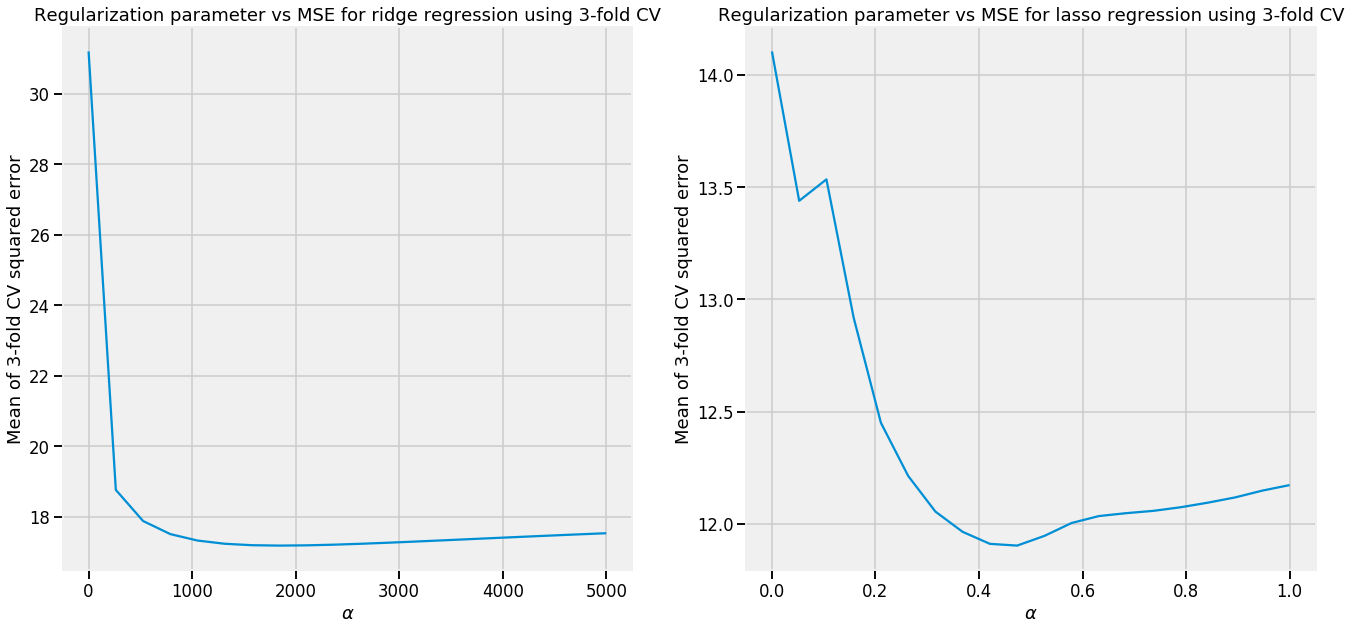

In [25]:
# possible solution
alphas_ridge = np.linspace(0.01,5000, 20)
alphas_lasso = np.linspace(0, 1, 20)

plt.figure(figsize = (20,10))

plt.subplot(121)
plt.plot(alphas_ridge, model_cv_mse(Ridge, X_all_train, y_all_train, alphas_ridge, 3))
plt.title("Regularization parameter vs MSE for ridge regression using 3-fold CV")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean of 3-fold CV squared error")

plt.subplot(122)
plt.plot(alphas_lasso, model_cv_mse(Lasso, X_all_train, y_all_train, alphas_lasso, 3))
plt.title("Regularization parameter vs MSE for lasso regression using 3-fold CV")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean of 3-fold CV squared error")

plt.show()

**Question 3.4** Comment on the plots above. How does the MSE change with different alphas for ridge vs lasso?

**Answer** Many answers accepted as long as they're relevant to the plots above; ridge MSEs stay relatively constant at high enough alpha but Lasso MSEs have a clearer minimum, and are larger at low or high alphas.

**Question 3.5** Now, repeat the plotting exercise in question 3.3 but use the California-only data. You'll create two subplots: one that shows alpha vs. cross-validated MSE for ridge regression for the training portion of the California dataset, and one that shows alpha vs cross-validated MSE for lasso regression for the training portion of the California dataset. Use 3-fold CV.

As with question 3.3, you'll want to use trial and error to figure out what range of alphas to plot for each model. Similar to question 3.3, your ridge plot will be "L" shaped, and your lasso plot will be more convex.

Make sure to add axis labels and titles.

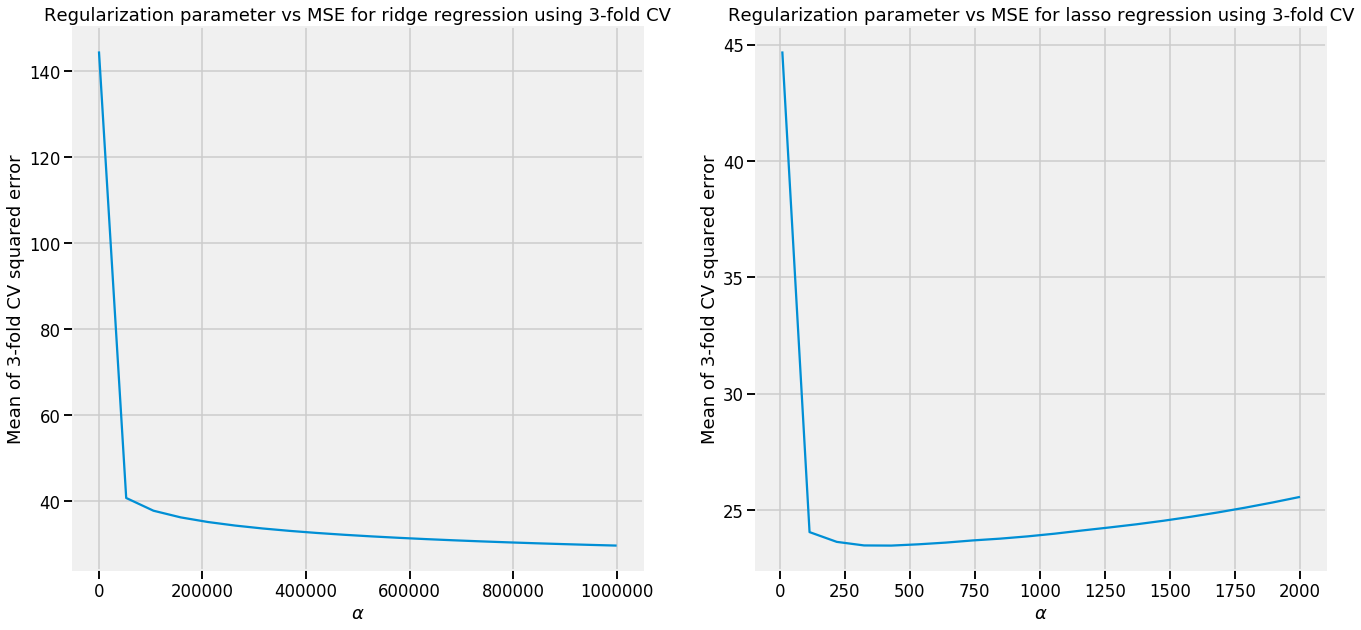

In [26]:
# possible solution
alphas_ridge = np.linspace(0,1000000, 20)
alphas_lasso = np.linspace(10, 2000, 20)

plt.figure(figsize = (20,10))

plt.subplot(121)
plt.plot(alphas_ridge, model_cv_mse(Ridge, X_ca_train, y_ca_train, alphas_ridge, 3))
plt.title("Regularization parameter vs MSE for ridge regression using 3-fold CV")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean of 3-fold CV squared error")

plt.subplot(122)
plt.plot(alphas_lasso, model_cv_mse(Lasso, X_ca_train, y_ca_train, alphas_lasso, 3))
plt.title("Regularization parameter vs MSE for lasso regression using 3-fold CV")
plt.xlabel(r"$\alpha$")
plt.ylabel("Mean of 3-fold CV squared error")

plt.show()

**Question 3.6** Comment on the plots in question 3.5. How do they differ from the plots in question 3.3? In particular, think about the following questions: 
* is there a larger relative improvement in MSE when alpha increases with models fit to the full dataset, or the California dataset? Why might that be?
* How does the roughly optimal alpha value for Lasso regression for the model fit to the California data compare to the roughly optimal alpha value for Lasso regression for the model fit to the full dataset? Can you explain the difference between the values? (of course, different datasets will lead to different optimal alphas - but try to go one step beyond that explanation and think about the role that sample size and variance might be playing here)

**Answer** Many answers are acceptable, but students should note the larger relative improvement with the California dataset at higher alphas and the larger optimal California dataset alpha (~3 orders of magnitude larger). A complete answer will also discuss how with the smaller California dataset, there's higher variance and a greater risk of overfitting, which is why a larger penalty value (alpha) leads to better model performance on new data - it penalizes overfitting to reduce variance.

**Question 3.7:** Now that we've seen both lasso and ridge regression in use, how do ridge regression and the lasso improve on ordinary least squares? In what cases would you expect ridge regression to perform better than lasso, and vice versa? 

**Answer** Many answers are acceptable; a complete answer should discuss how adding a penalty term in lasso and ridge leads to a reduction in variance compared to OLS (i.e. they avoid overfitting); ridge performs better than lasso when the number of features in the real model is larger; lasso performs better when the number of features in the real model is smaller, and when the data is susceptible to high variance due to small sample sizes.

## Section 4: Comparing optimal models<a name='compare'></a>

In this section, we'll compare the performance of three models: your Lasso model with optimal alpha, your Ridge model with optimal alpha, and Novotny's model.

**Question 4.1:** Let's start by getting the optimal alpha and corresponding coefficients of the Ridge model. In this section, we'll use a new scikit-learn function, [`RidgeCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html). `RidgeCV()` takes as an input a list of alpha values and a cross-validation splitter object (which is just the output of the function `KFold(...)`).

To call `RidgeCV()`, you would want to first create a cross-validation object using `Kfold()`:

`kf = KFold(n_splits = ..., shuffle = ..., random_state = ...)`

You can then pass `kf` to `RidgeCV()`, along with a list of alpha values:

`ridgecv = RidgeCV(cv = kf, alphas = ...)`

and you can treat it essentially like any other `scikit-learn` model by calling `.fit()`:

`ridgecv.fit(X_train, y_train)`

Running the code above will, in one line, perform cross-validation, choose an ideal alpha from your list, and select the corresponding coefficients. You can then access the optimal alpha using:

`ridgecv.alpha_`

and the corresponding coefficients using:

`ridgecv.coef_`

You can also get predictions on your test data using `.predict()`:

`ridgecv.predict(X_test)`

In the cell below, we've written some skeleton code to get you started. You'll want to call `RidgeCV()` using 3-fold cross validation with a random state of 0, train the model on the training data for the **full** dataset (i.e. `X_all_train, y_all_train`), get predictions for the test data (i.e. `X_all_test`), and find the mean-squared-error on your cross-validated ridge model on the test data. Save the mean squared error to variable `ridgecv_mse`.

You may also want to print the optimal alpha value to make sure it's consistent with your plot in question 3.3.

You can use the same range of alphas that you did for plotting, or you can choose to use a smaller, larger, or more granular range.

In [28]:
# solution
from sklearn.linear_model import RidgeCV

alphas_ridge = np.linspace(0, 600, 200)

kf = KFold(n_splits = 3, shuffle = True, random_state = 0)
ridgecv = RidgeCV(cv = kf, alphas=alphas_ridge)
ridgecv.fit(X_all_train, y_all_train)

alpha_opt = ridgecv.alpha_
print("optimal alpha:", alpha_opt)

y_pred_ridgecv = ridgecv.predict(X_all_test)

ridgecv_mse = mean_squared_error(y_pred_ridgecv, y_all_test)
print("Test MSE with cross-validated Ridge:", ridgecv_mse)

optimal alpha: 600.0
Test MSE with cross-validated Ridge: 16.101613928104005


/srv/app/venv/lib/python3.6/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


**Question 4.2:** Now, let's get the optimal alpha and corresponding coefficients of the Lasso model. We'll use the function [`LassoCV()`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). As in question 4.1, `LassoCV()` takes as an input a list of alpha values and a cross-validation splitter object (which is just the output of the function `KFold(...)`). You would call `LassoCV()` and use it to fit a model, get predictions, and access the alpha and coefficient values in the same way you would `RidgeCV()`.

In this section, you'll want to call `LassoCV()` using 3-fold cross validation with a random state of 0, train the model on the training data for the **full** dataset (i.e. `X_all_train, y_all_train`), get predictions for the test data, and find the mean-squared-error on your cross-validated ridge model on the test data. Save the mean squared error to variable `lassocv_mse`.

You may also want to print the optimal alpha value to make sure it's consistent with your plot in question 3.3. Note that it's not unusual if LassoCV() returns an optimal alpha that's slightly different than the alpha that shows up at the minimum point in your plot in question 3.3, due to how LassoCV() solves for coefficients. However, the alpha value should be within a reasonable range of the minimum alpha you get in question 3.3.

Again, you can use the same range of alphas that you did for plotting, or you can choose to use a smaller, larger, or more granular range.

In [30]:
# solution
from sklearn.linear_model import LassoCV

alphas_lasso = np.linspace(0, 2, 200)

kf = KFold(n_splits = 3, shuffle = True, random_state = 0)
lassocv = LassoCV(cv = kf, alphas=alphas_lasso)
lassocv.fit(X_all_train, y_all_train)

alpha_opt = lassocv.alpha_
print("optimal alpha:", alpha_opt)

y_pred_lassocv = lassocv.predict(X_all_test)

lassocv_mse = mean_squared_error(y_pred_lassocv, y_all_test)
print("Test MSE with cross-validated Lasso:", lassocv_mse)

optimal alpha: 1.2964824120603016
Test MSE with cross-validated Lasso: 10.29566902495813


As an aside: at this point, you might be asking yourself why we wrote the function in Question 3.1 when we can use `RidgeCV()` and `LassoCV()`. While `RidgeCV()` and `LassoCV()` are very useful for getting optimal alphas and corresponding coefficients and mean squared errors, it's harder to extract the cross-validated mean squared error for a *list* of alphas from those functions (particularly from `LassoCV()`). We wanted you to have both tools (a self-written function that calculates MSE across alphas, and scikit-learn provided functions that return the optimal alpha and coefficients) at your disposal.

Moving on!

**Question 4.3** Now, let's see how Novotny's model performed. The list `X_nov` below are the predictors that they put in their final model data set.  Use that list to fit a multiple linear regression model whose predictors is just the predictors listed in `X_nov`.  Fit the linear regresion model to the training dataset we've been using throughout the lab (`X_all_train, y_all_train`) but select only the columns in `X_nov` from that training set. Then calculate the mean squared error between the model's prediction on the test data set (i.e. `X_test`, but containing only the columns in `X_nov`) and the actual data for the test set.  Save the MSE value to `novotny_mse`.

In [31]:
# Run this block
X_nov = ['WRF+DOMINO',
       'Impervious_800', 'Elevation_truncated_km', 'Major_800',
       'Resident_100', 'Distance_to_coast_km']

In [32]:
X_nov_train = X_all_train.loc[:,X_nov]
X_nov_test = X_all_test.loc[:,X_nov]

novotny = LinearRegression()
novotny.fit(X_nov_train, y_all_train)

y_pred_nov = novotny.predict(X_nov_test)

novotny_mse = mean_squared_error(y_pred_nov, y_all_test)
print("Test MSE with Novotny model:", novotny_mse)

Test MSE with Novotny model: 11.027084459391313


**Question 4.4** Which model performs best?  

*Your answer here*

**Question 4.5** In this question, we compared the MSE of 3 models. Name and describe one other metric we could use to compare models. How do you think the relative model performance of ridge, lasso, and Novotny's model would differ using that metric?

Many answers are possible; for full marks students should address all parts of the question (name and describe the metric and consider how it would rank ridge, lasso, and Novotny's model).

## Section 5: Project<a name='proj'></a>

For the project-related questions in this homework, we're going to step back and regroup! We know that projects have evolved since you first put down your ideas in HW4. In this section, we're going to re-ask some questions from earlier to get a sense of where you're at now with the project, and then we'll ask a question to get you thinking about the division of work in your group.

**Question 5.1** What prediction questions will your group be exploring? Ultimately, we want you to ask one question per student in your group.

*Your answer here*

**Question 5.2** What data sources will you be using? You should aim for 1 + $N_s$ data sources, where $N_s$ is the number of students in your group.

*Your answer here*

**Question 5.3** So far, what has everyone's contribution been to the project? Everyone in your group should answer this question individually.

*Your answer here*

**Question 5.4** How do you envision dividing the workload of the project among your group members? Try to think through all the different phases of the project, from cleaning data to modeling and analysis and visualization.

*Your answer here*

----

## Submission

Congrats, you're done with homework 8!

Before you submit, click **Kernel** --> **Restart & Clear Output**. Then, click **Cell** --> **Run All**. Then, go to the toolbar and click **File** -> **Download as** -> **.html** and submit the file **as both an .html and .ipynb file through bCourses**.

----

## Bibliography

https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/



---
Notebook developed by: Alex Nakagawa

Data Science Modules: http://data.berkeley.edu/education/modules
